This post part of my series [TensorFlow From The Ground Up]({category}tensorflow-from-the-ground-up).

In my previous post [Learning to Add]({filename}Learning to Add.md), I showed how a Neural Network architecture can learn a simple linear function of two variables.  

In this post, we'll explore how to take our functions from linear to nonlinear.  Additionally, we'll work on going some **regressions** and see what happens when we try to learn nonlinear functions. 

## Composing linear functions

One of the key points of linear functions is that the composition of two linear functions is also a linear function.  The math behind this is fairly straightforward: 

$$\begin{array}{rl}
f(x) & = wx+b \\
f(f(x)) & = w_2(w_1x+b_1)+b_2 \\
& = (w_2w_1)x+(w_2b_1+b_2) \\
\end{array}$$

As you can see, the composed form of $f(f(x))$ is also a linear function, just with $w = w_2w_1$ and $b = w_2b_1+b_2$

Or, to think of this differently:  Without any **nonlinear elements** in our neural network architecture, there's no reason to have any more than one node in the middle layer, because even a giant collection of linear functions still result in a single linear transformation.  

An exception to this is functions of multiple variables, like $f(x,y) = \{a,b\}$  We can work the math backwards, but let it suffice to say that for functions of $N$ inputs and $M$ outputs, we need no more than $\max(N,M)$ linear 
nodes in the middle layer. 


## How do we introduce nonlinearity?

All we need to do is apply some elementwise nonlinear function to all the values in the middle layer of our network.  It ends up making our computation graph look like this: 

$$\begin{array}{rl}
middle\ layer & = input \times W_{mid} + B_{mid} \\
middle\ nonlinear & = f(middle\ layer) \\ 
output & = (midle\ nonlinear) \times W_{out} + B_{out}
\end{array}$$

It's that easy, we just need to choose the right nonlinear function to insert there.  Thankfully, this has been heavily researched, and there are 3 very commonly used functions:

* **sigmoid** : ``tf.nn.sigmoid``
* **tanh** : ``tf.nn.tanh``
* **ReLu**  : ``tf.nn.relu``

The best way to get a grasp on these is to look at them visually, so here we go: 

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

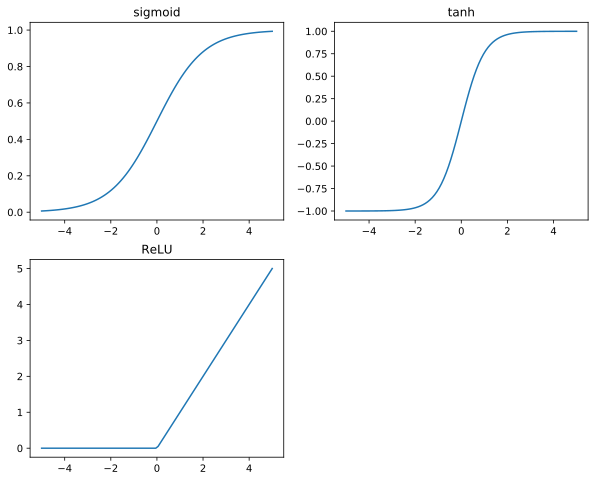

In [55]:
import math
import numpy as np 
import matplotlib.pyplot as plt 

def sigmoid(x): return 1 / (1 + math.exp(-x))
def relu(x):
    if x>0: 
        return x
    else: return 0 

x = np.linspace(-5,5, 100)
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
plt.plot(x, [sigmoid(v) for v in x])
plt.title("sigmoid")

plt.subplot(2,2,2)
plt.plot(x, np.tanh(x))
plt.title("tanh")

plt.subplot(2,2,3)
plt.plot(x, [relu(v) for v in x])
plt.title("ReLU")
plt.show()

## Simple Example

As an example of computation that requires nonlinear units, I'd like to propose that we implement a function like this: 
$$f(x) = \begin{cases}
    1.0, & \text{if } \lfloor x \rfloor == 42 \\
    0,         & \text{otherwise}
\end{cases}
$$

This function isn't easily expressed through any combination of linear operators.  Additionally, the fact that the output should be either 1.0 or 0.0 after training suggests that we should use the **sigmoid** function for activation of the neuron(s) in the network. 

In [98]:
import math
import tensorflow as tf 
import random

def f(x): 
    if math.floor(x) == 42.0: 
        return 1 
    return 0

i = tf.placeholder(shape=(None, 1), dtype=tf.float32, name='input')
o = tf.placeholder(shape=(None, 1), dtype=tf.float32, name='output')

num_hidden = 4

i_w = tf.Variable(expected_shape=(1, num_hidden), 
                initial_value=tf.random_normal((1, num_hidden), mean=1, stddev=0.1))
i_b = tf.Variable(expected_shape=(1, num_hidden), 
                initial_value=tf.random_normal((1, num_hidden), mean=0, stddev=0.1))

mid = tf.nn.sigmoid(tf.add(tf.matmul(i, i_w), i_b))

o_w = tf.Variable(
    expected_shape=(num_hidden, 1), 
    initial_value=tf.random_normal((num_hidden, 1), mean=1, stddev=0.1))
o_b = tf.Variable(
    expected_shape=(1, 1), 
    initial_value=tf.random_normal((1, 1), mean=0, stddev=0.1))

output = tf.nn.sigmoid(tf.add(tf.matmul(mid, o_w), o_b))

# Our error function is computed as "Mean Squared Difference" between the computed output
# and the expected value. 
loss = tf.pow(output - o, 2)
mean_loss = tf.reduce_mean(loss)

# Learning rate and optimizer similar to our previous examples. 
learning_rate = 0.001
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

with tf.Session() as sess: 
    sess.run([tf.local_variables_initializer(), 
              tf.global_variables_initializer()])
    
    print "TRAIN"
    batch_size = 100
    train_iterations = 30000
    for step in xrange(train_iterations):
        feed = {i:[], o:[]}
        for b in xrange(batch_size):
#            v = random.uniform(0, 100)
#            feed[i].append([v,])
#            feed[o].append([f(v),])
            v = random.uniform(40, 50)
            feed[i].append([v,])
            feed[o].append([f(v),])
        _, l, out = sess.run([optimizer, mean_loss, output], feed_dict=feed)
        if step % 1000 == 0:
            print "step =",step," loss=", l
            
    print "VALIDATE"
    validate_iterations = 15
    for step in xrange(validate_iterations):
        feed = {i:[], o:[]}
        v = random.uniform(41, 44)
        feed[i].append([v,])
        feed[o].append([f(v),])
        _, l, out = sess.run([optimizer, mean_loss, output], feed_dict=feed)
        print "in = ", feed[i], "output =", out, "expected = ", f(v), " loss=", l


TRAIN
step = 0  loss= 0.877057
step = 1000  loss= 0.104496
step = 2000  loss= 0.0742236
step = 3000  loss= 0.0900399
step = 4000  loss= 0.12191
step = 5000  loss= 0.0979266
step = 6000  loss= 0.0819742
step = 7000  loss= 0.113891
step = 8000  loss= 0.0578795
step = 9000  loss= 0.0500379
step = 10000  loss= 0.0979864
step = 11000  loss= 0.122138
step = 12000  loss= 0.0740604
step = 13000  loss= 0.0980238
step = 14000  loss= 0.113875
step = 15000  loss= 0.0980144
step = 16000  loss= 0.114098
step = 17000  loss= 0.0819586
step = 18000  loss= 0.0819596
step = 19000  loss= 0.122212
step = 20000  loss= 0.0979735
step = 21000  loss= 0.0579728
step = 22000  loss= 0.0739617
step = 23000  loss= 0.0499344
step = 24000  loss= 0.0740566
step = 25000  loss= 0.0335692
step = 26000  loss= 0.0900009
step = 27000  loss= 0.0900244
step = 28000  loss= 0.065831
step = 29000  loss= 0.0900088
VALIDATE
in =  [[42.418392103505745]] output = [[ 0.09433614]] expected =  1  loss= 0.820227
in =  [[41.2733168245037

## You should play with this code a little bit.

Here's a collection of random ideas for how to play around with the code example above and gain some insights:

* Modify the "f()" function to try other linear combinations of x & y.  Can it learn $x-y$?  Can it learn $0.5x + 0.75y - 0.33$? 
* Modify the size of the middle layer.  We use 2 middle layer nodes.  What if you use 200?  How does that impact learning rate?   
* Modify the size of the middle layer, and have it try to learn something "Hard" like $x\cdot y$. Did it work?  Do you have any thoughts about why or why not?